# Figure 1: Carbachol affects DG-CA3 excitatory and inhibitory transmission

In [1]:
%matplotlib inline

import numpy as np
from neo.io import NeoHdf5IO
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt,lfilter

try:
    from stfio.stfio_plot import plot_scalebars
    sb=True
except ImportError:
    sb=False

## Data processing functions 

In [2]:
def filter_psc(psc,samp_freq,kwidth=0.0003):
    '''Filter PSCs with narrow gaussian filter'''
    k = gauss_kernel(kwidth,samp_freq,8*kwidth) # filter window is 8 standard deviations
    fpsc =filtfilt(k,[1],psc)
    return fpsc


def gauss_kernel(sigma,sample_rate,duration):
    '''Gaussian kernel shape'''
    l = duration*sample_rate
    x = np.arange(-np.floor(l/2),np.floor(l/2))/sample_rate
    y = (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x**2/(2*sigma**2))) # normal distribution
    y/=sum(y) # area sums to 1
    return y


def extract_batch_amps(traces,samp_freq,tbase,latency,win,argm):
    '''Extract all PSC amplitudes from traces'''
    
    traces = np.array(traces)
    ftraces = [filter_psc(trace,samp_freq) for trace in traces]
    batch_amps = [extract_psc_amps(ftrace,tbase,latency,win,argm) for ftrace in ftraces]
    return batch_amps


def extract_psc_amps(trace,tbase,latency,win,argm):
    
    '''Extract PSC amplitude from single trace'''
    trace_amps = []
    tbase = int(tbase*25000)
    latency = int(latency*25000)
    win = int(win*25000)
    for i in range(4):
        start = i*len(trace)/4
        psc = trace[start:start+latency+tbase]
        base = np.mean(psc[tbase-10:tbase])
        peak = argm(psc[latency-win:latency+win])
        amp = peak - base
        trace_amps.append(amp)
    return trace_amps


def load_data(path):
    '''Load data from .h5 file'''
    r = NeoHdf5IO(path)
    blks = r.read_all_blocks()
    r.close
    data = [blk.segments[0].analogsignalarrays[0] for blk in blks]
    return data

## Plotting functions

In [3]:
def remove_upper_right_ticks(ax):
    '''Remove and lines from upper and right edges of figure'''
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
def stim_artefact_removal(trace_list):
    '''Remove stim artefacts from trace'''
    for i in xrange(4):
        ix = i*1250
        sa = 25
        for trace in trace_list:
            trace[ix:ix+sa] = np.zeros(sa)
    return trace_list

def plot_dcgiv_block_example(data,n,colors,figsize=(8,6)):
    '''Plot example traces of DCG-IV block'''
    
    ctrl = [x[:,:10]for x in data] # Control taken from first 10 samples
    dcgiv = [x[:,-10:] for x in data] # Effect taken from last 10 samples
    
    fig = plt.figure(figsize=figsize)

    time = np.linspace(0,200,5000)
    trace1 = ctrl[n] # select only traces from cell n
    trace2 = dcgiv[n]

    plt.plot(time,trace1.mean(axis=1),colors[0],linewidth=3) # plot average trace
    plt.plot(time,trace2.mean(axis=1),'k',linewidth=3)

    ax = plt.gca()
    
    if sb:
        plot_scalebars(ax,xunits='ms',yunits='pA') # add scalebar
        plt.axis('off'); # remove axis lines
    
    plt.legend(('Control','1 $\mathrm{\mu}$M DCG-IV'),fontsize=16,frameon=False,loc='best')
    
    return fig

def plot_dcgiv_time_series(data,sig_dict,colors,figsize=(6,3)):
    '''Plot progression of DCG-IV effect over time'''
    
    # Extract PSC amplitudes from data
    data_amps_all = np.array([extract_batch_amps(traces.T,
                                             samp_freq=sig_dict['samp_freq'],
                                             tbase=sig_dict['tbase'],
                                             latency=sig_dict['latency'],
                                             win=sig_dict['win'],
                                             argm=sig_dict['argm']) for traces in data])

    fig =plt.figure(figsize=(6,3))

    n = min([len(d) for d in data_amps_all]) # find length of shortest recording
    X = []
    # Normalise each trace to average of first 10 samples without drug present (control)
    for x in data_amps_all:
        x = np.array(x)
        x = x.T[3]
        norm = (x[:10]).mean()
        X.append(x[:n]/norm)

    X = np.array(X)
    ma_win = 3

    S = X.std(axis=0)[ma_win-1::3]/len(data_amps_all) # standard error
    M = lfilter(np.ones(ma_win)/ma_win,[1],X.mean(axis=0))[ma_win-1::3] # average every three samples
    T = np.arange(len(S)) + 1

    # means and standard error of the mean
    l1= plt.errorbar(T,M,yerr=S,
                     fmt='o',color=colors[0],ecolor=colors[0],ms=5)[0]

    # Show line for y = 1, i.e., no effect
    plt.axhline(y=1.0,lw=1,ls='--',color='k')
    
    # Change background color to gray to indicate time of drug application
    plt.axvspan(xmin=11/3.,xmax=n/3.,color='#A59A9A',alpha=0.25)
    
    return fig

def plot_cch_example(data,n,colors,remove_stimaf,figsize=(9,3)):
    
    '''Plot example average traces of Control and CCh effect'''
    
    ctrl = [x[:,:10]for x in data] # Take first 10 traces as control
    cch = [x[:,-10:] for x in data] # Take last 10 traces as effect
    
    time = np.linspace(0,200,5000)
    
    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=figsize)

    trace1 = ctrl[n].mean(axis=1) # Select only the nth cell to average over
    trace2 = cch[n].mean(axis=1)
    
    # Remove Stim Artefact if True
    if remove_stimaf:
        trace1,trace2 = stim_artefact_removal([trace1,trace2])

    l1 = ax1.plot(time,trace1,colors[0],linewidth=3)[0]
    ax1.set_title('Control',fontsize=20)
    
    # Insert scalebars
    if sb:
        plot_scalebars(ax1,xunits='ms',yunits='pA')
        ax1.axis('off') # remove axis
        ax2.axis('off') # remove axis

    l2 = ax2.plot(time,trace2,colors[1],linewidth=3)[0]
    ax2.set_title('5 $\mathrm{\mu}$M CCh',fontsize=20)

    
    return fig
    
def plot_cch_amps(data,sig_dict,colors,figsize=(4,4)):
    
    '''Plot amplitudes of PSC before and after CCh as a bar chart'''
    
    ctrl = [x[:,:10]for x in data] # First 10 samples are control
    cch = [x[:,-10:] for x in data] # Last 10 samples are effect
    
    # Extract amplitudes from control data
    ctrl_amps_all = [extract_batch_amps(traces.T,
                                        samp_freq=sig_dict['samp_freq'],
                                        tbase=sig_dict['tbase'],
                                        latency=sig_dict['latency'],
                                        win=sig_dict['win'],
                                        argm=sig_dict['argm']) for traces in ctrl]
    
    # Extract amplitudes from effect data
    cch_amps_all = [extract_batch_amps(traces.T,
                                       samp_freq=sig_dict['samp_freq'],
                                       tbase=sig_dict['tbase'],
                                       latency=sig_dict['latency'],
                                       win=sig_dict['win'],
                                       argm=sig_dict['argm']) for traces in cch]
    
    # Get means of extracted amplitudes from each cell
    ctrl_means = np.squeeze([np.mean(c,axis=0) for c in ctrl_amps_all])
    cch_means = np.squeeze([np.mean(d[-10:],axis=0) for d in cch_amps_all])

    fig = plt.figure(figsize=figsize)
    
    L = len(ctrl_means.T) # Number of PSCs
    N = len(ctrl_means) # Number of cells
    plt.bar(range(L),np.mean(cch_means,axis=0)/np.mean(ctrl_means,axis=0),
                 yerr=np.std(cch_means/ctrl_means,axis=0)/N,color=colors[0],ecolor='k')
    plt.xticks(np.arange(L),np.arange(L)+1,fontsize=16)
    
    return fig,[ctrl_means,cch_means]

def plot_cch_ppr(means,sig_dict,colors,figsize=(4,4)):
    
    '''Plot nth pulse ratio of PSCs before and after carbachol'''
    
    ctrl_means,cch_means = means
    
    # Nth pulse ratio: ratio between nth pulse and 1st pulse where n > 1
    ctr_ppr = (ctrl_means.T[1:]/ctrl_means.T[0].mean()).T
    cch_ppr = (cch_means.T[1:]/cch_means.T[0].mean()).T

    fig = plt.figure(figsize=figsize)
    width = 0.4
    plt.bar(np.arange(3),np.mean(ctr_ppr,axis=0),
                 yerr=np.std(ctr_ppr,axis=0)/8,color=colors[0],ecolor='k',width=width)
    plt.bar(np.arange(3)+width,np.mean(cch_ppr,axis=0),
                 yerr=np.std(cch_ppr,axis=0)/8,color=colors[1],ecolor='k',width=width)
    
    plt.xticks(np.arange(3)+width/2,range(2,5),fontsize=16)
    
    
    plt.xlabel('Pulse num',fontsize=16)
    plt.ylabel('Ratio',fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('$\mathrm{n^{th}}$ Pulse Ratio',fontsize=18)
    plt.legend(['Control','CCh 5 $\mathrm{\mu}$M'],fontsize=16)
    return fig

def plot_cch_time_series(data,wodata,colors,wo_ix,npsc,sig_dict,figsize=(12,3)):
    
    # Extract amplitudes for washin data
    data_amps_all = np.array([extract_batch_amps(traces.T,
                                             samp_freq=sig_dict['samp_freq'],
                                             tbase=sig_dict['tbase'],
                                             latency=sig_dict['latency'],
                                             win=sig_dict['win'],
                                             argm=sig_dict['argm']) for traces in data])
    # Extract amplitudes for washout data
    wodata_amps_all = np.array([extract_batch_amps(traces.T,
                                                   samp_freq=sig_dict['samp_freq'],
                                                   tbase=sig_dict['tbase'],
                                                   latency=sig_dict['latency'],
                                                   win=sig_dict['win'],
                                                   argm=sig_dict['argm']) for traces in wodata])
    iterdata = iter(wodata_amps_all)

    fig,axs =plt.subplots(sharey=True,figsize=figsize,ncols=2,nrows=1)
    
    # Minumum lengths of washin and washout data

    n = min([len(d) for d in data_amps_all])
    n2 = min([len(d) for d in wodata_amps_all])

    X = []
    X2 = []
    
    # Not all washout data was complete, so normalise to control only for complete datasets
    
    for ix,x in enumerate(data_amps_all):
        x = np.array(x)
        x = x.T[npsc]
        norm = (x[:10]).mean()
        X.append(x[:n]/norm)
        if ix in wo_ix:
            x2 = np.array(iterdata.next())
            x2 = x2.T[npsc]
            X2.append(x2[:n2]/norm)

    X = np.array(X)
    X2 = np.array(X2)

    ma_win = 3
    
    # Standard error and means over 3 trials

    S1 = X.std(axis=0)[ma_win-1::3]/len(data_amps_all)
    M1 = lfilter(np.ones(ma_win)/ma_win,[1],X.mean(axis=0))[ma_win-1::3]
    S2 = X2.std(axis=0)[ma_win-1::3]/len(wodata_amps_all)
    M2 = lfilter(np.ones(ma_win)/ma_win,[1],X2.mean(axis=0))[ma_win-1::3]

    T1 = np.arange(len(S1)) + 1
    T2 = np.arange(len(S2)) + 550/60 + T1[-1]

    plt.sca(axs[0])

    # Plot washin data
    plt.errorbar(T1,M1,yerr=S1,
                 fmt='o',color=colors[0],ecolor=colors[0],ms=5)
    
    # Insert line at y=1
    plt.axhline(y=1.0,lw=1,ls='--',color='k')
    
    # Change background to grey where washin started
    plt.axvspan(xmin=T1[3],xmax=T1[-1]+0.5,color='#A59A9A',alpha=0.25)
    plt.xlim(T1[0]-0.5,T1[-1]+0.5)

    plt.sca(axs[1])
    # Plot washout data
    plt.errorbar(T2,M2,yerr=S2,
                fmt='o',color=colors[0],ecolor=colors[0],ms=5)
    
    # Insert line at y=1
    plt.axhline(y=1.0,lw=1,ls='--',color='k')
    
    # Change background to grey before washout started
    plt.axvspan(xmin=T2[0]-0.5,xmax=T2[3],color='#A59A9A',alpha=0.25)
    plt.xlim(T2[0]-0.5,T2[-1]+0.5)
    
    return fig

### Processing and plotting parameters

In [4]:
# Dictionary to describe data processing parameters for EPSCs and IPSCs
esig_dict = {'samp_freq':25000,'tbase':0.001,'latency':0.002,'win':0.002,'argm':np.min}
isig_dict = {'samp_freq':25000,'tbase':0.005,'latency':0.009,'win':0.003,'argm':np.max}

# Colors for excitatory (reds) and inhibitory (blues)
ecolors = ['#F41111',"maroon"]
icolors = ['#454FE8','#75A4F7']

## MF-EPSC DCG-IV effect

In [5]:
data = load_data(path='./fig1_data/dcgiv_epsc.h5')
fig = plot_dcgiv_block_example(data,n=4,colors=ecolors)
plt.title('Mossy Fibre EPSCs Blocked By DCG-IV',fontsize=20);

# Adjustments for paper
# fig.set_size_inches(3,2)
# fig.axes[0].legend_.remove()
# fig.text(0.33,0.95,'1 $\mathrm{\mu M}$ DCG-IV',fontsize=12)
# [txt.set_fontsize(14) for txt in fig.axes[0].texts];
# fig.savefig('./reworked_figs/mf-epsc-dvg4-example.svg')

AttributeError: 'NeoHdf5IO' object has no attribute 'close'

## Time course of MF-EPSC DCG-IV effect

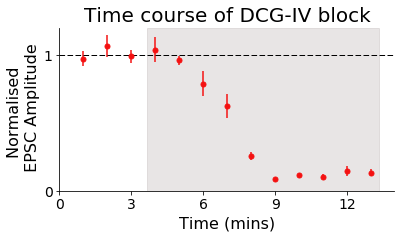

In [6]:
fig = plot_dcgiv_time_series(data,sig_dict=esig_dict,colors=ecolors)
remove_upper_right_ticks(plt.gca())
plt.ylabel('Normalised \n EPSC Amplitude', fontsize=16)
plt.xlabel('Time (mins)',fontsize=16)

plt.xticks((0,3,6,9,12),fontsize=14)
plt.yticks((0,1.0),fontsize=14);
plt.title('Time course of DCG-IV block', fontsize=20)

# Adjustments for paper
# fig.set_size_inches(2,1)
# fig.axes[0].set_title('',fontsize=20,y=1.1)
# fig.text(0.45,0.95,'DCG-IV',fontsize=14)
# fig.savefig('./reworked_figs/mf-epsc-dvg4-time.svg')

## Example traces of effects of Carbachol on MF-EPSCs

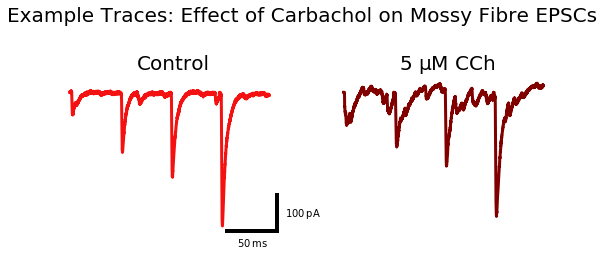

In [7]:
data = load_data(path='./fig1_data/cch_epsc.h5')
fig = plot_cch_example(data,n=6,colors=ecolors,remove_stimaf=True)

fig.suptitle('Example Traces: Effect of Carbachol on Mossy Fibre EPSCs', fontsize=20,y=1.2)

# [txt.set_fontsize(14) for txt in fig.axes[0].texts];
# fig.savefig('./reworked_figs/mf-epsc-cch-example.svg')

## Carbachol effect on EPSC amplitudes normalised to control

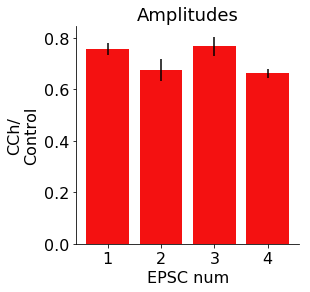

In [9]:
fig,means = plot_cch_amps(data,colors=ecolors,sig_dict=esig_dict)
remove_upper_right_ticks(plt.gca())
plt.xlabel('EPSC num',fontsize=16)
plt.ylabel('CCh/\nControl',fontsize=16)
plt.yticks(np.linspace(0,0.8,5),fontsize=16)
plt.title('Amplitudes',fontsize=18);

# fig.set_size_inches(1.5,1.5)
# fig.savefig('./reworked_figs/mf-epsc-cch-amps.svg')

In [56]:
print (means[1]).mean(axis=0)/(means[0]).mean(axis=0), np.std(means[1]/means[0],axis=0)
print (means[1]).mean()/(means[0]).mean(), np.std(means[1]/means[0])

[ 0.75647285  0.67583483  0.76672146  0.66201361] [ 0.17031093  0.29949592  0.25990337  0.11920568]
0.704099715448 0.229471570419


In [33]:
epsc_amps_data = np.hstack(means)
with open('./fig1_data/epsc_amps.csv','w') as myfile:
    np.savetxt(myfile,epsc_amps_data,delimiter=',')

In [28]:
ctrl_means,cch_means = means

# Nth pulse ratio: ratio between nth pulse and 1st pulse where n > 1
ctr_ppr = (ctrl_means.T[1:]/ctrl_means.T[0].mean()).T
cch_ppr = (cch_means.T[1:]/cch_means.T[0].mean()).T

In [32]:
epsc_ppr_data = np.hstack((ctr_ppr,cch_ppr))
with open('./fig1_data/epsc_ppr.csv','w') as myfile:
    np.savetxt(myfile,epsc_ppr_data,delimiter=',')

##  Carbachol effect on MF-EPSC nth pulse ratio

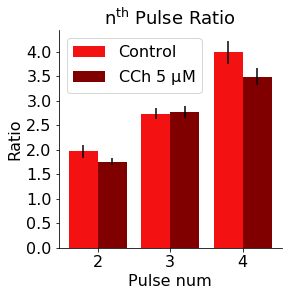

In [169]:
fig = plot_cch_ppr(means,colors=ecolors,sig_dict=esig_dict)
remove_upper_right_ticks(plt.gca())

# fig.set_size_inches(1.5,1.5)
# fig.axes[0].legend_.remove()
# fig.savefig('./reworked_figs/mf-epsc-cch-npr.svg')

## Time Course of Carbachol effect on  MF-EPSC amplitudes: washin and washout

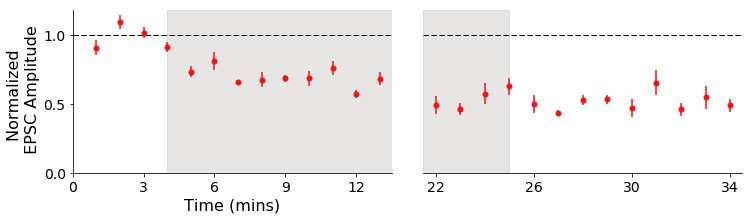

In [170]:
wodata = load_data(path='./fig1_data/cch_wo_epsc.h5')
fig = plot_cch_time_series(data,wodata,wo_ix=[2,4,5,6],npsc=3,colors=ecolors,sig_dict=esig_dict)

for ax in fig.axes:
    remove_upper_right_ticks(ax)
    plt.sca(ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.sca(fig.axes[0])
plt.yticks([0,0.5,1.0],fontsize=14)
plt.ylabel('Normalized \n EPSC Amplitude', fontsize=16)
plt.xlabel('Time (mins)',fontsize=16)
plt.xticks(np.linspace(0,12,5))

fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].yaxis.set_ticks_position('none')
plt.sca(fig.axes[1])
plt.yticks([0,0.5,1.0])
plt.xticks(np.linspace(22,34,4))

fig.subplots_adjust(wspace=0.1)
# fig.suptitle('Time course of Carbachol effect on Mossy Fibre EPSCs',fontsize=20,y=1.1)

# fig.set_size_inches(4.5,1.5)
# fig.savefig('./reworked_figs/mf-epsc-cch-time.svg')

## MF-IPSC DCG-IV effect

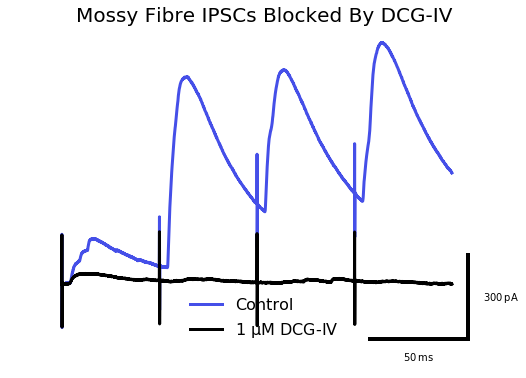

In [10]:
data = load_data(path='./fig1_data/dcgiv_ipsc.h5')
fig = plot_dcgiv_block_example(data,n=3,colors=icolors)
plt.title('Mossy Fibre IPSCs Blocked By DCG-IV',fontsize=20);

# Adjustments for paper
# fig.set_size_inches(3,2)
# fig.axes[0].legend_.remove()
# fig.axes[0].set_title('IPSC',fontsize=20,y=1.1)
# [txt.set_fontsize(14) for txt in fig.axes[0].texts];
# fig.savefig('./reworked_figs/mf-ipsc-dvg4-example.svg')

## Time course of MF-IPSC DCG-IV effect

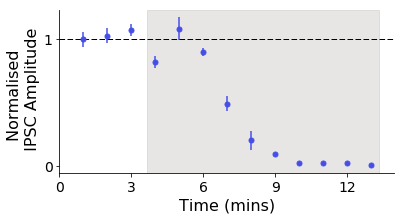

In [11]:
fig = plot_dcgiv_time_series(data,sig_dict=isig_dict,colors=icolors)
remove_upper_right_ticks(plt.gca())
plt.ylabel('Normalised \n IPSC Amplitude', fontsize=16)
plt.xlabel('Time (mins)',fontsize=16)

plt.xticks((0,3,6,9,12),fontsize=14)
plt.yticks((0,1.0),fontsize=14);
#plt.title('Time course of DCG-IV block', fontsize=20)

# Adjustments for paper
# fig.set_size_inches(2,1)
# fig.text(0.33,0.95,'1 $\mathrm{\mu M}$ DCG-IV',fontsize=12)
# fig.savefig('./reworked_figs/mf-ipsc-dvg4-time.svg')

## Example traces of MF-IPSC before and after carbachol

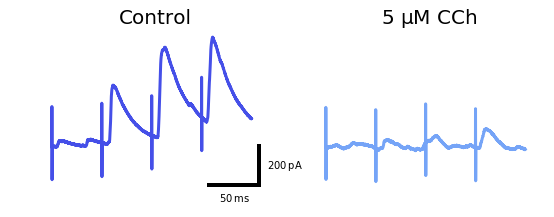

In [12]:
data = load_data(path='./fig1_data/cch_ipsc.h5')
data = data[:5]
fig = plot_cch_example(data,n=1,colors=icolors,remove_stimaf=False)
# fig.suptitle('Example Traces: Effect of Carbachol on Mossy Fibre IPSCs', fontsize=20,y=1.2)

# [txt.set_fontsize(14) for txt in fig.axes[0].texts];
# fig.savefig('./reworked_figs/mf-ipsc-cch-example.svg')

## Effect of Carbachol on MF-IPSC amplitudes normalised to control

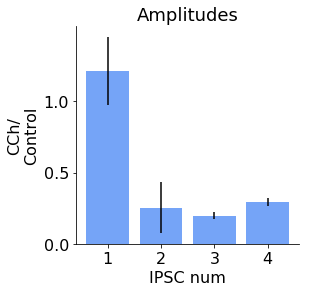

In [13]:
fig,means = plot_cch_amps(data,colors=[icolors[1]],sig_dict=isig_dict)
remove_upper_right_ticks(plt.gca())
plt.xlabel('IPSC num',fontsize=16)
plt.ylabel('CCh/\nControl',fontsize=16)
plt.yticks(np.linspace(0,1.0,3),fontsize=16)
plt.title('Amplitudes',fontsize=18);

# fig.set_size_inches(1.5,1.5)
# fig.savefig('./reworked_figs/mf-ipsc-cch-amps.svg')

##  Effect of carbachol on MF-IPSC nth pulse ratio

([<matplotlib.axis.YTick at 0x7fcc5a687090>,
 <a list of 5 Text yticklabel objects>)

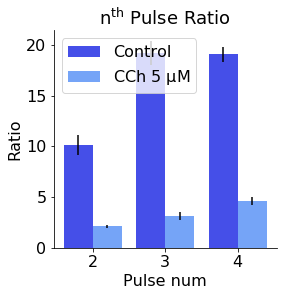

In [59]:
fig = plot_cch_ppr(means,colors=icolors,sig_dict=isig_dict)
remove_upper_right_ticks(plt.gca())

plt.yticks(np.linspace(0,20,5),fontsize=16)

# fig.set_size_inches(1.5,1.5)
# fig.axes[0].legend_.remove()
# fig.savefig('./reworked_figs/mf-ipsc-cch-npr.svg')

In [60]:
print (means[1]).mean(axis=0)/(means[0]).mean(axis=0), np.std(means[1]/means[0],axis=0)
print (means[1]).mean()/(means[0]).mean(), np.std(means[1]/means[0])

[ 1.2153102   0.25325803  0.198371    0.29305876] [ 1.19454266  0.89580483  0.12874764  0.13539195]
0.26674957643 0.965593871781


In [61]:
ipsc_amps_data = np.hstack(means)
with open('./fig1_data/ipsc_amps.csv','w') as myfile:
    np.savetxt(myfile,ipsc_amps_data,delimiter=',')

In [15]:
ctrl_means,cch_means = means

# Nth pulse ratio: ratio between nth pulse and 1st pulse where n > 1
ctr_ppr = (ctrl_means.T[1:]/ctrl_means.T[0].mean()).T
cch_ppr = (cch_means.T[1:]/cch_means.T[0].mean()).T

In [16]:
ipsc_ppr_data = np.hstack((ctr_ppr,cch_ppr))
with open('./fig1_data/ipsc_ppr.csv','w') as myfile:
    np.savetxt(myfile,ipsc_ppr_data,delimiter=',')

## Time course of carbachol effect on MF-IPSC amplitudes: washin and washout

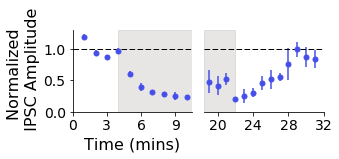

In [165]:
wodata = load_data(path='./fig1_data/cch_wo_ipsc.h5')
fig = plot_cch_time_series(data,wodata,wo_ix=[2,4],npsc=3,colors=icolors,sig_dict=isig_dict)

for ax in fig.axes:
    remove_upper_right_ticks(ax)
    plt.sca(ax)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.sca(fig.axes[0])
plt.yticks([0,0.5,1.0],fontsize=14)
plt.ylabel('Normalized \n IPSC Amplitude', fontsize=16)
plt.xlabel('Time (mins)',fontsize=16)
plt.xticks(np.linspace(0,9,4))

fig.axes[1].spines['left'].set_visible(False)
fig.axes[1].yaxis.set_ticks_position('none')
plt.sca(fig.axes[1])
plt.yticks([0,0.5,1.0])
plt.xticks(np.linspace(20,32,4))

fig.subplots_adjust(wspace=0.1)
#fig.suptitle('Time course of Carbachol effect on Mossy Fibre IPSCs',fontsize=20,y=1.1)

# fig.set_size_inches(4.5,1.5)
# fig.savefig('./reworked_figs/mf-ipsc-cch-time.svg')